In [3]:
import matplotlib.pyplot as plt

In [13]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)
print(faces.target_names)
print(faces.images.shape)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)


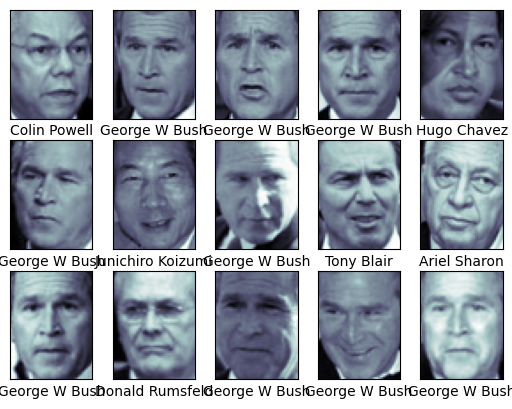

In [8]:
fig, ax = plt.subplots(3, 5)
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='bone')
    axi.set(xticks=[], yticks=[],
            xlabel=faces.target_names[faces.target[i]])

In [ ]:
 # Chaque image contient [62×47] soit près de 3 000 pixels. On pourrait procéder simplement
#en utilisant chaque valeur de pixel comme fonctionnalité, mais il est souvent plus efficace d'utiliser une sorte de
# préprocesseur pour extraire des fonctionnalités plus significatives ; ici nous utiliserons une ACP pour
# extraire 150 composants fondamentaux pour alimenter notre classificateur de SVM.
# Nous pouvons le faire plus simplement en empaquetant le préprocesseur et le classificateur en un seul pipeline :

In [10]:
from sklearn.svm import SVC
#from sklearn.decomposition import RandomizedPCA
from sklearn.decomposition import PCA as RandomizedPCA
from sklearn.pipeline import make_pipeline
pca = RandomizedPCA(n_components=150, whiten=True, random_state=42)
svc = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(pca, svc)

In [12]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(faces.data, faces.target,random_state=42)

In [ ]:
# Enfin, nous pouvons utiliser une validation croisée de recherche par grille pour explorer des combinaisons de paramètres.
# Ici, nous ajusterons C (qui contrôle la dureté de la marge) et gamma (qui contrôle la taille du noyau de la fonction de base radiale) et détermine le meilleur modèle :

In [15]:
from sklearn.model_selection import GridSearchCV
param_grid = {'svc__C': [1, 5, 10, 50],'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}
grid = GridSearchCV(model, param_grid)

In [16]:
%time grid.fit(Xtrain, ytrain)
print(grid.best_params_)

CPU times: total: 5min 30s
Wall time: 1min 7s
{'svc__C': 5, 'svc__gamma': 0.001}


In [ ]:
# Les valeurs optimales se situent vers le milieu de notre grille ; s'ils tombaient sur les bords, nous nous voudrions étendre la grille pour nous assurer que nous avons trouvé le véritable optimal.
# Désormais, grâce à ce modèle à validation croisée, nous pouvons prédire les étiquettes des données de test, ce qui
# le modèle n'a pas encore vu :

In [17]:
model = grid.best_estimator_
yfit = model.predict(Xtest)

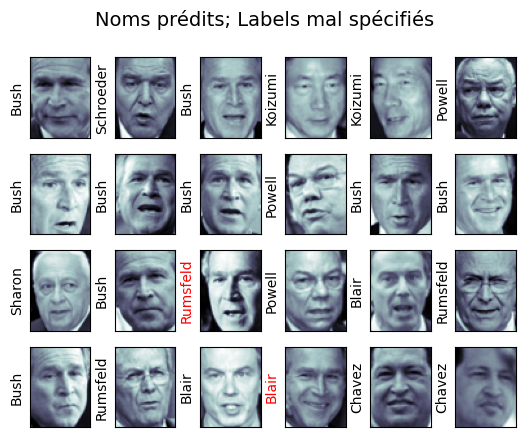

In [19]:
fig, ax = plt.subplots(4, 6)
for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest[i].reshape(62, 47), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(faces.target_names[yfit[i]].split()[-1],
                   color='black' if yfit[i] == ytest[i] else 'red')
fig.suptitle('Noms prédits; Labels mal spécifiés', size=14);

In [ ]:
# Sur ce petit échantillon, notre estimateur optimal n’a mal étiqueté qu’un seul visage (le modèle de Bush
# le visage dans la rangée du bas était étiqueté à tort comme étant Blair). Nous pouvons avoir une meilleure idée de la valeur de notre estimateur
# performances à l'aide du rapport de classification, qui répertorie les statistiques de récupération
# étiquette par étiquette :

In [20]:
from sklearn.metrics import classification_report
print(classification_report(ytest, yfit,
target_names=faces.target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.65      0.87      0.74        15
     Colin Powell       0.83      0.88      0.86        68
  Donald Rumsfeld       0.70      0.84      0.76        31
    George W Bush       0.97      0.80      0.88       126
Gerhard Schroeder       0.76      0.83      0.79        23
      Hugo Chavez       0.93      0.70      0.80        20
Junichiro Koizumi       0.86      1.00      0.92        12
       Tony Blair       0.82      0.98      0.89        42

         accuracy                           0.85       337
        macro avg       0.82      0.86      0.83       337
     weighted avg       0.86      0.85      0.85       337



In [22]:
import seaborn as sns

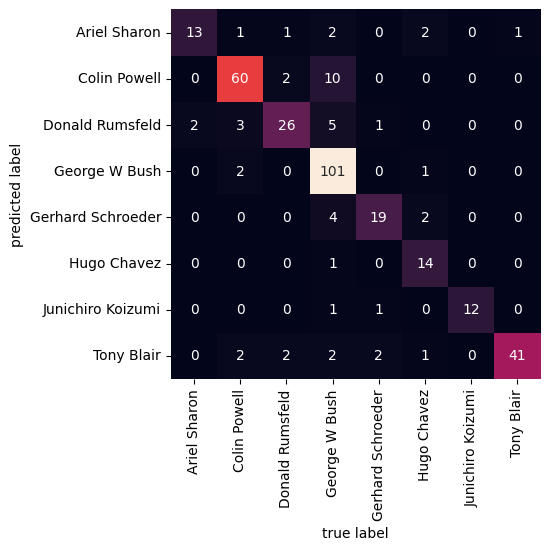

In [23]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest, yfit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
xticklabels=faces.target_names,
yticklabels=faces.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');